# Esse notebook permite a análise e a exclusão de imagens .fits obtidas com a SPARC4 a partir dos shifts calculados pelo pipeline

## Vamos começar gerando um arquivo .txt a partir dos valores dos headers das imagens de um determinado objeto. O notebook funciona para qualquer número de canais. É importante que as imagens em todos os canais analisados tenham sido capturadas simultaneamente.

In [3]:
import os
from pathlib import Path
from astropy.io import fits
import matplotlib.pyplot as plt

# --- 1. Configuração de caminhos
base = Path('/media/fernando/SSD2/Doutorado/2025/reduced/20250709_remove_clouds')
channels = ['sparc4acs1','sparc4acs2','sparc4acs3','sparc4acs4'] # Aqui não é necessário indicar todos os 4 canais, ou seja, pode-se fazer a análise para canais individualmente ou para grupos de canais de qualquer tamanho.
target = "foaqrl4" # Sufixo do objeto que queremos analisar as imagens.
suffix = f"{target}_proc.fits"

# --- 2. Carrega e ordena os arquivos de cada canal
files_per_ch = []
for ch in channels:
    p = base/ch
    files = sorted([f for f in p.iterdir() if f.name.endswith(suffix)])
    files_per_ch.append(files)

# --- 3. Conta e verifica múltiplos
counts = [len(lst) for lst in files_per_ch]
min_count = min(counts)
if any(c % min_count != 0 for c in counts):
    raise RuntimeError(f'Contagens não são múl­tiplos entre si: {counts}')

ratios = [c // min_count for c in counts]

# --- 4. Extrai shifts e checa status
xsh = [[] for _ in range(len(channels))]
ysh = [[] for _ in range(len(channels))]
alerts = []

for i in range(min_count):
    for j in range(len(channels)):
        idx = i * ratios[j]
        f = files_per_ch[j][idx]
        hdr = fits.getheader(f, 0)
        x = hdr.get('XSHIFT', 'NaN')
        y = hdr.get('YSHIFT', 'NaN')
        xst = hdr.get('XSHIFTST', 'OK')
        yst = hdr.get('YSHIFTST', 'OK')
        xsh[j].append(x)
        ysh[j].append(y)
        if xst != 'OK' or yst != 'OK':
            alerts.append(f"{f.name}: XSHIFTST={xst}, YSHIFTST={yst}")

# --- 5. Gera o TXT
out = base/f"shifts_summary_{target}.txt"
with open(out, 'w') as fw:
    # cabeçalho
    hdr = ['idx'] + [f'XSHIFT_{k+1}' for k in range(len(channels))] + [f'YSHIFT_{k+1}' for k in range(len(channels))]
    fw.write("\t".join(hdr) + "\n")
    # linhas
    for i in range(min_count):
        row = [str(i+1)]
        row += [str(xsh[j][i]) for j in range(len(channels))]
        row += [str(ysh[j][i]) for j in range(len(channels))]
        fw.write("\t".join(row) + "\n")

print(f"Arquivo gravado em: {out}")
if alerts:
    print("⚠️ Alertas de status:")
    print("\n".join(alerts))
else:
    print("Todos XSHIFTST e YSHIFTST = 'OK'.")

Arquivo gravado em: /media/fernando/SSD2/Doutorado/2025/reduced/20250709_remove_clouds/shifts_summary_foaqrl4.txt
Todos XSHIFTST e YSHIFTST = 'OK'.


## Agora vamos analisar esses shifts:

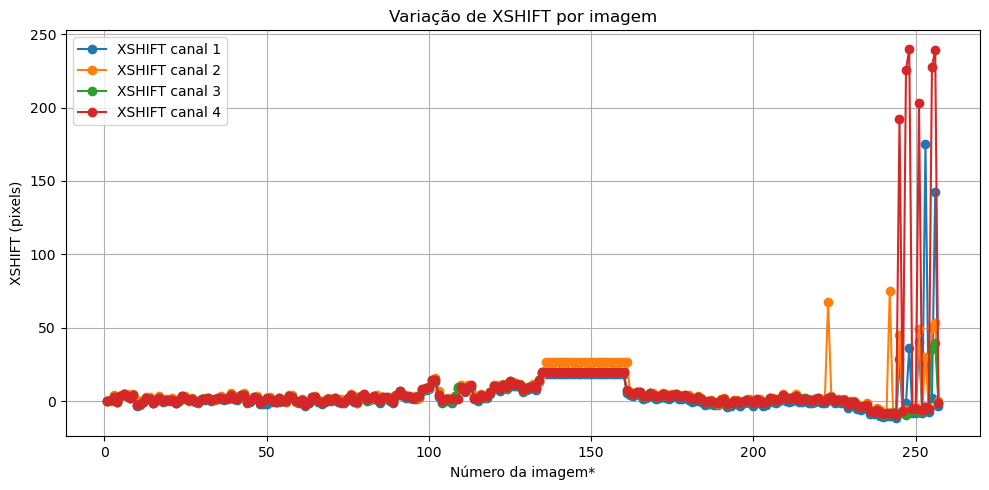

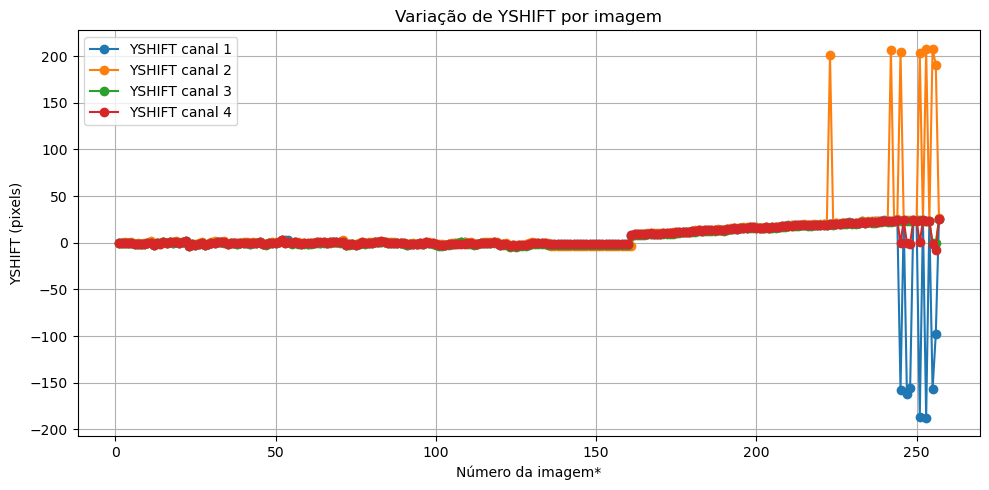

*Para o canal 2 esse número deve ser multiplicado por 2.


In [6]:
# Caminho para o arquivo
txt_path = out

# Inicializa listas
indices = []
xshifts = [[] for _ in range(len(channels))]
yshifts = [[] for _ in range(len(channels))]

# Lê o arquivo, ignorando o cabeçalho
with open(txt_path, 'r') as f:
    lines = f.readlines()[1:]

for line in lines:
    parts = line.strip().split('\t')
    if len(parts) < ((len(channels)*2)+1):
        continue
    indices.append(int(parts[0]))
    for i in range(len(channels)):
        xshifts[i].append(float(parts[1 + i]))
        yshifts[i].append(float(parts[(len(channels)+1) + i]))

# Gráfico de XSHIFT
plt.figure(figsize=(10, 5))
for i in range(len(channels)):
    plt.plot(indices, xshifts[i], marker='o', label=f'XSHIFT canal {i+1}')
plt.xlabel('Número da imagem*')
plt.ylabel('XSHIFT (pixels)')
plt.title('Variação de XSHIFT por imagem')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de YSHIFT
plt.figure(figsize=(10, 5))
for i in range(len(channels)):
    plt.plot(indices, yshifts[i], marker='o', label=f'YSHIFT canal {i+1}')
plt.xlabel('Número da imagem*')
plt.ylabel('YSHIFT (pixels)')
plt.title('Variação de YSHIFT por imagem')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




###PRINT###
# Encontra os índices e valores onde o valor é diferente de 1
diferentes = [(i+1, val) for i, val in enumerate(ratios) if val != 1]

if not diferentes:
    print()
else:
    if len(diferentes) == 1:
        idx, val = diferentes[0]
        print(f"*Para o canal {idx} esse número deve ser multiplicado por {val}.")
    else:
        canais = [str(d[0]) for d in diferentes]
        valores = [str(d[1]) for d in diferentes]
        # Monta a string com "e" antes do último elemento
        canais_str = " e ".join([", ".join(canais[:-1]), canais[-1]]) if len(canais) > 1 else canais[0]
        valores_str = " e ".join([", ".join(valores[:-1]), valores[-1]]) if len(valores) > 1 else valores[0]
        print(f"*Para os canais {canais_str}, esse número deve ser multiplicado por {valores_str}, respectivamente.")

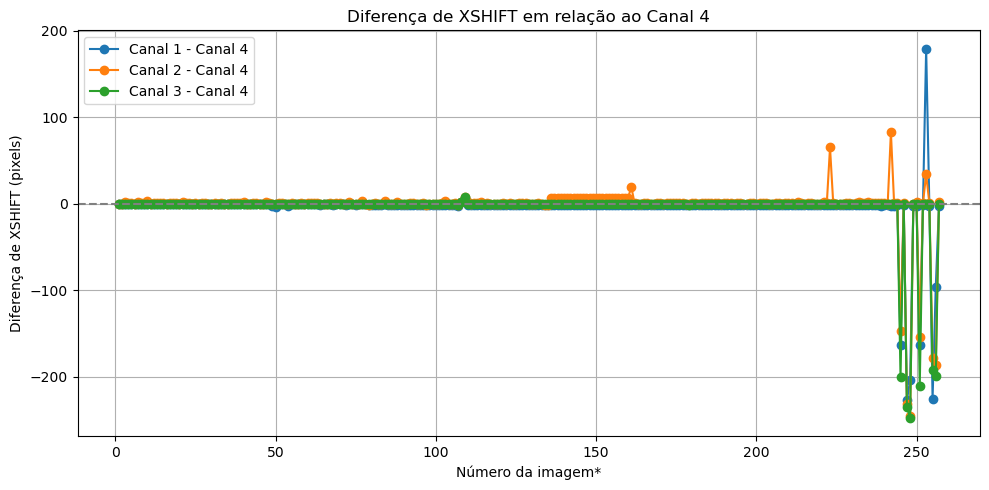

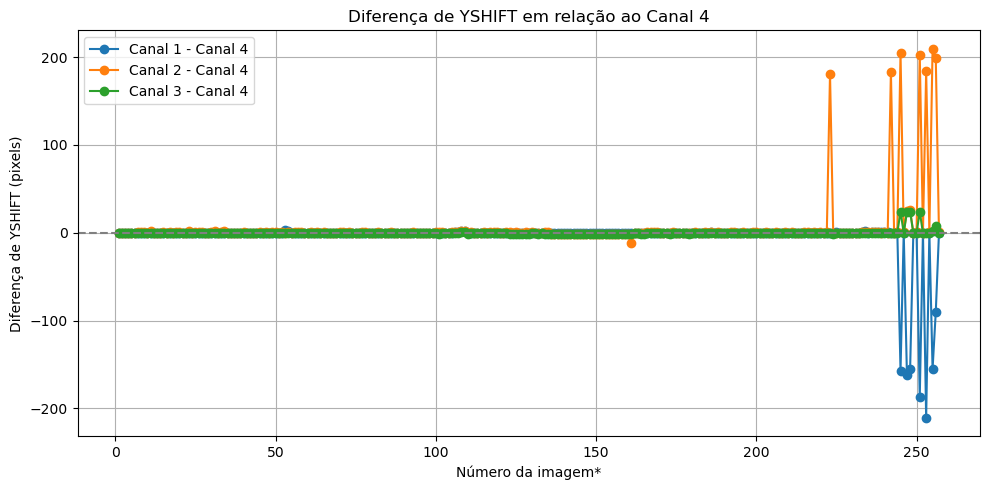

*Para o canal 2 esse número deve ser multiplicado por 2.


In [8]:
num_channels = len(channels)
ref = num_channels - 1  # índice do canal de referência (último)

xshift_diffs = [
    [xshifts[ch][i] - xshifts[ref][i] for i in range(len(indices))]
    for ch in range(num_channels - 1)  # todos menos o último
]

yshift_diffs = [
    [yshifts[ch][i] - yshifts[ref][i] for i in range(len(indices))]
    for ch in range(num_channels - 1)
]

# Gerar cores automaticamente (usando colormap para distinguir bem)
cmap = plt.get_cmap("tab10")  # paleta com boa distinção de cores
colors = [cmap(i) for i in range(num_channels - 1)]

# Labels dinâmicos
labels = [f"Canal {i+1} - Canal {ref+1}" for i in range(num_channels - 1)]

# Gráfico de diferenças de XSHIFT
plt.figure(figsize=(10, 5))
for i in range(num_channels - 1):
    plt.plot(indices, xshift_diffs[i], marker='o', color=colors[i], label=labels[i])
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Número da imagem*')
plt.ylabel('Diferença de XSHIFT (pixels)')
plt.title(f'Diferença de XSHIFT em relação ao Canal {ref+1}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de diferenças de YSHIFT
plt.figure(figsize=(10, 5))
for i in range(num_channels - 1):
    plt.plot(indices, yshift_diffs[i], marker='o', color=colors[i], label=labels[i])
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Número da imagem*')
plt.ylabel('Diferença de YSHIFT (pixels)')
plt.title(f'Diferença de YSHIFT em relação ao Canal {ref+1}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

###PRINT###
# Encontra os índices e valores onde o valor é diferente de 1
diferentes = [(i+1, val) for i, val in enumerate(ratios) if val != 1]

if not diferentes:
    print()
else:
    if len(diferentes) == 1:
        idx, val = diferentes[0]
        print(f"*Para o canal {idx} esse número deve ser multiplicado por {val}.")
    else:
        canais = [str(d[0]) for d in diferentes]
        valores = [str(d[1]) for d in diferentes]
        # Monta a string com "e" antes do último elemento
        canais_str = " e ".join([", ".join(canais[:-1]), canais[-1]]) if len(canais) > 1 else canais[0]
        valores_str = " e ".join([", ".join(valores[:-1]), valores[-1]]) if len(valores) > 1 else valores[0]
        print(f"*Para os canais {canais_str}, esse número deve ser multiplicado por {valores_str}, respectivamente.")

# Vamos agora excluir todas as imagens com shifts estranhos (muito provavelmente por conta da passagem de nuvens).

## Determinando a lista de imagens com shifts ruins:

Valor extra por canal: [634, 930, 930, 717]
Número de imagens por canal: [257, 514, 257, 257]
Step por canal: [1, 2, 1, 1]


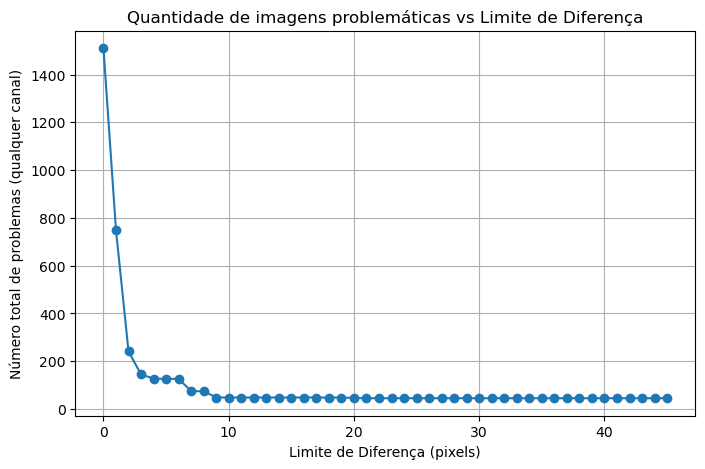


Canal 1 (257 imagens, valor_extra=634, step=1):
  Limite 0: 256 imagens -> [635, 636, 637, 638, 639, 640, 641, 642, 643, 644] ...
  Limite 1: 208 imagens -> [636, 640, 643, 644, 645, 647, 654, 655, 656, 658] ...
  Limite 2: 121 imagens -> [643, 644, 664, 682, 683, 686, 687, 706, 710, 717] ...
  Limite 3: 49 imagens -> [643, 683, 706, 710, 717, 736, 742, 769, 770, 771] ...
  Limite 4: 37 imagens -> [683, 742, 769, 770, 771, 772, 773, 774, 775, 776] ...
  Limite 5: 36 imagens -> [742, 769, 770, 771, 772, 773, 774, 775, 776, 777] ...
  Limite 6: 36 imagens -> [742, 769, 770, 771, 772, 773, 774, 775, 776, 777] ...
  Limite 7: 35 imagens -> [769, 770, 771, 772, 773, 774, 775, 776, 777, 778] ...
  Limite 8: 35 imagens -> [769, 770, 771, 772, 773, 774, 775, 776, 777, 778] ...
  Limite 9: 10 imagens -> [794, 856, 875, 878, 880, 881, 884, 886, 888, 889] ...
  Limite 10: 10 imagens -> [794, 856, 875, 878, 880, 881, 884, 886, 888, 889] ...
  Limite 11: 10 imagens -> [794, 856, 875, 878, 880, 881

In [12]:
#Essa parte cria um gráfico que mostra a diferença entre os valores dos shifts em pixels em função do número de imagens.
#Por exemplo, eu tenho um conjunto com 8000 imagens nos 4 canais da SPARC4 (aqui estamos considerando que todos os canais possuem o mesmo número de imagens).
#Comparando os valores dos shifts (tanto faz se em x ou em y) das 4 imagens capturadas simultaneamente nos 4 canais, esses valores devem ser muito parecidos (o shift em x deve ser teoricamente o mesmo para as 4 imagens, já que um movimento do telescópio criará um mesmo shift para os 4 canais).
#Mas alguma diferença nesse shifts deve ser tolerada (por variações no foco ou na própria determinação desses shifts).
#O eixo x do gráfico mostra a tolerância que eu tenho pra essa diferença nos shifts.
#Pode existir uma imagem em que o shift calculado para o canal 1 seja 4 pixels diferente do shift calculado para o canal 3. Essa imagem está errada? Não sei.
#Mas se o gráfico mostra que existem mais de 2000 imagens que possuem essa característica, ou seja, algum canal está com um shift pelo menos 4 pixels diferente de outro canal.
#4 pixels pode não ser um problema, mas 40 com certeza é. Uma diferença muito grande no shift de uma imagem capturada simultaneamente em todos os canais é um indício forte de que houve algum problema na determinação do shift dessa imagem.
#Esse problema pode indicar que a imagem em si está comprometida (muitas vezes pela passagem de nuvens).
#O gráfico a seguir mostra que para diferenças acima de 7 pixels, o número de imagens permanece constante, ou seja, para essas imagens existem diferenças nos shifts muito maiores do que 7 pixels. Isso é um forte indício de que existem problemas nessas imagens.
#A seguir, vamos analisar quais são essas imagens e possivelmente excluí-las da nossa redução.
#O parâmetro "valor_extra" serve para corrigir o número inicial da primeira imagem, por exemplo, se a primeira imagem do meu objeto é a 00083 (pois eu capturei 82 imagens de outros objetos antes de iniciar a captra desse objeto) eu devo adicionar o valor 82 para todos os valores da lista de imagens com problema (assim eu garanto que estou excluindo as imagens certas).

import itertools
import re
X_axis_max_number=45

# --- 1. Preparar informações por canal ---
valor_extra = []
num_imgs = []
steps = []

# Quantidade mínima de imagens entre os canais (usado para calcular step)
min_imgs = min(len(files) for files in files_per_ch)

for files in files_per_ch:
    # Extrair números das imagens (trecho "_000697_" no nome)
    numeros = []
    for f in files:
        m = re.search(r"_(\d+)_", f.name)
        if m:
            numeros.append(int(m.group(1)))
    
    menor_num = min(numeros) if numeros else 0
    valor_extra.append(menor_num)
    num_imgs.append(len(files))
    
    # Step = fator de repetição em relação ao canal com menos imagens
    steps.append(len(files) // min_imgs)

print("Valor extra por canal:", valor_extra)
print("Número de imagens por canal:", num_imgs)
print("Step por canal:", steps)

# --- 2. Detectar problemas ---
limites = list(range(X_axis_max_number+1))
tamanhos_totais = []
problemas_por_limite = {lim: [] for lim in limites}  # armazena info detalhada

for limite_diferenca in limites:
    idxs_problema = set()

    # Comparar todos os pares (XSHIFT e YSHIFT)
    for i in range(len(indices)):
        for a, b in itertools.combinations(range(len(channels)), 2):
            dif_x = abs(xshifts[a][i] - xshifts[b][i])
            dif_y = abs(yshifts[a][i] - yshifts[b][i])
            if dif_x > limite_diferenca or dif_y > limite_diferenca:
                idxs_problema.add((i, a, b))  # guarda o índice e o par de canais
    
    # Armazenar resultados brutos
    problemas_por_limite[limite_diferenca] = list(idxs_problema)
    tamanhos_totais.append(len(idxs_problema))

# --- 3. Converter para offset por canal com expansão conforme steps ---
idxs_problema_com_offset = {ch: {} for ch in range(len(channels))}

for limite_diferenca in limites:
    problemas = problemas_por_limite[limite_diferenca]
    for ch in range(len(channels)):
        # Filtra os problemas onde o canal 'ch' estava envolvido
        indices_afetados = sorted(set(
            i for i, a, b in problemas if ch in (a, b)
        ))
        # Aplica offset e step, expandindo índices quando step > 1
        offsets_expandidos = []
        for i in indices_afetados:
            base_offset = valor_extra[ch] + i * steps[ch]
            # Expande os índices conforme o step
            offsets_expandidos.extend(range(base_offset, base_offset + steps[ch]))
        
        # Remove possíveis duplicados e ordena
        idxs_problema_com_offset[ch][limite_diferenca] = sorted(set(offsets_expandidos))

# --- 4. Plotar gráfico geral ---
plt.figure(figsize=(8, 5))
plt.plot(limites, tamanhos_totais, marker='o')
plt.xlabel("Limite de Diferença (pixels)")
plt.ylabel("Número total de problemas (qualquer canal)")
plt.title("Quantidade de imagens problemáticas vs Limite de Diferença")
plt.grid(True)
plt.show()

# --- 5. Exemplo de relatório detalhado ---
for ch in range(len(channels)):
    print(f"\nCanal {ch+1} ({num_imgs[ch]} imagens, valor_extra={valor_extra[ch]}, step={steps[ch]}):")
    for limite in limites:
        print(f"  Limite {limite}: {len(idxs_problema_com_offset[ch][limite])} imagens -> {idxs_problema_com_offset[ch][limite][:10]} ...")

print(f"\nIMPORTANTE: O código sempre considera que a primeira imagem de cada canal está boa (ela não entra nas listas de imagens com problemas).")

## Determinando o treshold que queremos usar para excluir as imagens ruins:

In [33]:
#Essa célula serve apenas para que possamos saber quais imagens estão sendo consideradas ruins para um certo valor de diferença de shifts em comparação com outro valor, assim podemos avaliar se gostríamos de excluir essas imagens ou não.
#Por exemplo, tenho 313 imagens que possuem mais de 7 pixels de diferença nos shifts e 412 imagens que possuem mais de 6 pixels. Eu quero saber quais são essas 99 imagens (412 - 313) que possuem exatamente 7 pixels de diferença (mais de 6 e não mais de 7).
#Se eu achar que devo excluir essas 99 imagens, utilizo o valor de corte 6. Se eu achar que essas imagens ainda são boas, utilizo o valor de corte 7.

# --- Comparação entre dois limites ---
limite_1 = 9
limite_2 = 8

# --- Função adaptada ---
def calcula_indices(limite_diferenca, valor_extra_list, steps_list):
    """
    Calcula índices problemáticos para todos os canais, considerando offsets e steps.
    Retorna dois resultados por canal: sem offset e com offset.
    """
    idxs_problema_por_canal = [[] for _ in range(len(channels))]
    idxs_problema_offset_por_canal = [[] for _ in range(len(channels))]
    
    # 1. Detectar índices problemáticos (sem offset)
    for i in range(len(indices)):
        for a, b in itertools.combinations(range(len(channels)), 2):
            if abs(xshifts[a][i] - xshifts[b][i]) > limite_diferenca or \
               abs(yshifts[a][i] - yshifts[b][i]) > limite_diferenca:
                # Esse índice é problemático para todos os canais envolvidos
                idxs_problema_por_canal[a].append(indices[i])
                idxs_problema_por_canal[b].append(indices[i])
    
    # 2. Aplicar offset e steps para cada canal
    for ch in range(len(channels)):
        # Remove duplicados e ordena
        idxs_unicos = sorted(set(idxs_problema_por_canal[ch]))
        offset = valor_extra_list[ch]
        step = steps_list[ch]
        
        # Aplica offset e expande conforme steps
        idxs_com_offset = []
        for idx in idxs_unicos:
            base_idx = idx + offset
            if step > 1:
                idxs_com_offset.extend([base_idx + s for s in range(step)])
            else:
                idxs_com_offset.append(base_idx)
        
        idxs_problema_offset_por_canal[ch] = sorted(idxs_com_offset)
    
    return idxs_problema_por_canal, idxs_problema_offset_por_canal

# Usa os valores calculados na Parte 1
idxs_1, idxs_1_offset = calcula_indices(limite_1, valor_extra, steps)
idxs_2, idxs_2_offset = calcula_indices(limite_2, valor_extra, steps)

# --- Exibir resultados por canal ---
for ch in range(len(channels)):
    so_em_1 = sorted(set(idxs_1[ch]) - set(idxs_2[ch]))
    so_em_1_offset = sorted(set(idxs_1_offset[ch]) - set(idxs_2_offset[ch]))

    so_em_2 = sorted(set(idxs_2[ch]) - set(idxs_1[ch]))
    so_em_2_offset = sorted(set(idxs_2_offset[ch]) - set(idxs_1_offset[ch]))

    print(f"\n=== Canal {ch+1} ({channels[ch]}) ===")
    print(f"Limite {limite_1} mas não {limite_2} (sem offset) ({len(so_em_1)} imagens):", so_em_1)
    print(f"Limite {limite_1} mas não {limite_2} (com offset) ({len(so_em_1_offset)} imagens):", so_em_1_offset)
    print(f"Limite {limite_2} mas não {limite_1} (sem offset) ({len(so_em_2)} imagens):", so_em_2)
    print(f"Limite {limite_2} mas não {limite_1} (com offset) ({len(so_em_2_offset)} imagens):", so_em_2_offset)



=== Canal 1 (sparc4acs1) ===
Limite 9 mas não 8 (sem offset) (0 imagens): []
Limite 9 mas não 8 (com offset) (0 imagens): []
Limite 8 mas não 9 (sem offset) (25 imagens): [136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
Limite 8 mas não 9 (com offset) (25 imagens): [770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794]

=== Canal 2 (sparc4acs2) ===
Limite 9 mas não 8 (sem offset) (0 imagens): []
Limite 9 mas não 8 (com offset) (0 imagens): []
Limite 8 mas não 9 (sem offset) (25 imagens): [136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
Limite 8 mas não 9 (com offset) (25 imagens): [1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090]

=== Canal 3 (sparc4acs3) ===
Limit

In [35]:
# Parâmetros
limite_diferenca = 9  # Aqui é determinado o limite de diferença nos shifts. Ajuste conforme quiser.

lista_para_exclusao = []
for ch in range(len(channels)):
    exclusao=idxs_problema_com_offset[ch][limite_diferenca]
    lista_para_exclusao.append(exclusao)

# Mostrar resultados para cada canal
for ch in range(len(channels)):
    print(f"Canal {ch+1} ({channels[ch]}):")
    print(f"Índices com diferença acima do limite (com offset) ({len(lista_para_exclusao[ch])} imagens):", sorted(lista_para_exclusao[ch]))

Canal 1 (sparc4acs1):
Índices com diferença acima do limite (com offset) (10 imagens): [794, 856, 875, 878, 880, 881, 884, 886, 888, 889]
Canal 2 (sparc4acs2):
Índices com diferença acima do limite (com offset) (20 imagens): [1250, 1251, 1374, 1375, 1412, 1413, 1418, 1419, 1422, 1423, 1424, 1425, 1430, 1431, 1434, 1435, 1438, 1439, 1440, 1441]
Canal 3 (sparc4acs3):
Índices com diferença acima do limite (com offset) (10 imagens): [1090, 1152, 1171, 1174, 1176, 1177, 1180, 1182, 1184, 1185]
Canal 4 (sparc4acs4):
Índices com diferença acima do limite (com offset) (10 imagens): [877, 939, 958, 961, 963, 964, 967, 969, 971, 972]


## Gerando uma lista dos arquivos que serão excluídos:

In [38]:
from collections import defaultdict

# --- processamento de arquivos encontrados ---
arquivos_para_excluir = []
contagem_por_canal = defaultdict(int)

for canal, numeros in zip(channels, lista_para_exclusao):
    pasta = base / canal
    for numero in numeros:
        numero_str = f"{numero:06d}"
        pattern = f"*_{numero_str}_*{suffix}"
        arquivos = list(pasta.glob(pattern))
        arquivos_para_excluir.extend(arquivos)
        contagem_por_canal[canal] += len(arquivos)

# Modificar caminhos: remover "/reduced" e "_proc" antes de ".fits"
arquivos_para_excluir_modificados = [
    str(arq).replace('/reduced', '').replace('_proc.fits', '.fits')
    for arq in arquivos_para_excluir
]

# Imprimir caminhos modificados
for arq in arquivos_para_excluir_modificados:
    print(arq)

print(f"\nTotal de arquivos para exclusão: {len(arquivos_para_excluir)}")

print("\nQuantidade de arquivos para exclusão por canal:")
for canal in channels:
    print(f"{canal}: {contagem_por_canal[canal]}")

# Salvar a lista de caminhos modificados em um arquivo .txt
with open(base/"arquivos_excluidos.txt", "w") as f:
    for caminho in arquivos_para_excluir_modificados:
        f.write(caminho + "\n")

print(f"\nLista de arquivos a serem excluídos salva em '{base}/arquivos_excluidos.txt'.")

/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000794_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000856_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000875_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000878_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000880_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000881_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000884_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000886_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000888_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc

## Fazendo um backup dos arquivos que serão excluídos:

In [46]:
import shutil

txt_file = base / "arquivos_excluidos.txt"
backup_dir = base / "backup"

# Cria a pasta de backup se não existir
backup_dir.mkdir(exist_ok=True)

# Lê os caminhos dos arquivos
with open(txt_file, 'r') as f:
    arquivos = [line.strip() for line in f if line.strip()]

# Copia cada arquivo para o backup
for arq in arquivos:
    src = Path(arq)
    if src.exists():
        shutil.copy2(src, backup_dir / src.name)  # copy2 mantém metadados
    else:
        print(f"Arquivo não encontrado: {src}")

print(f"Backup concluído! Arquivos copiados para: {backup_dir}")


Backup concluído! Arquivos copiados para: /media/fernando/SSD2/Doutorado/2025/reduced/20250709_remove_clouds/backup


## Gerando um .gif dos arquivos que serão excluídos:

In [49]:
import numpy as np
import imageio.v2 as imageio
import io

frames = []

for arq in arquivos:
    with fits.open(arq) as hdul:
        img = hdul[0].data.astype(float)
        
        # Normalização simples para 0–255
        img -= np.nanmin(img)
        img /= np.nanmax(img)
        img = (img * 255).astype(np.uint8)
        
        # Converter para RGB (para evitar problemas de colormap)
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray', origin='lower')
        ax.axis('off')
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        buf.seek(0)
        
        frames.append(imageio.imread(buf))

# Salva o GIF
gif_path = base / "arquivos_excluidos.gif"
imageio.mimsave(gif_path, frames, duration=0.2)  # duration em segundos por frame

print(f"GIF criado em: {gif_path}")


GIF criado em: /media/fernando/SSD2/Doutorado/2025/reduced/20250709_remove_clouds/arquivos_excluidos.gif


# Excluíndo os arquivos:

In [54]:
# --- CONFIGURAÇÃO ---
confirmar = False  # <<< Altere para True quando quiser realmente excluir

# Lê os caminhos
with open(txt_file, 'r') as f:
    arquivos = [line.strip() for line in f if line.strip()]

# Mostra a lista de arquivos que serão excluídos
print("Arquivos listados para exclusão:")
for arq in arquivos:
    print(arq)

if not confirmar:
    print("\n⚠️ Exclusão NÃO confirmada. "
          "Altere a variável 'confirmar' para True e rode a célula novamente para excluir.")
else:
    excluidos = []
    nao_encontrados = []
    erros = []

    for arq in arquivos:
        try:
            p = Path(arq)
            if p.exists():
                os.remove(p)
                excluidos.append(arq)
            else:
                nao_encontrados.append(arq)
        except Exception as e:
            erros.append((arq, str(e)))

    # Resumo
    print("\nResumo da exclusão:")
    print(f"✅ Excluídos: {len(excluidos)}")
    print(f"❌ Não encontrados: {len(nao_encontrados)}")
    print(f"⚠️ Erros: {len(erros)}")

    if nao_encontrados:
        print("\nArquivos não encontrados:")
        for nf in nao_encontrados:
            print(nf)

    if erros:
        print("\nArquivos com erro na exclusão:")
        for arq, msg in erros:
            print(f"{arq} -> {msg}")


Arquivos listados para exclusão:
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000794_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000856_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000875_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000878_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000880_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000881_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000884_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000886_foaqrl4.fits
/media/fernando/SSD2/Doutorado/2025/20250709_remove_clouds/sparc4acs1/20250709_s4c1_000888_foaqrl4.fits
/media/fernando/SSD2/Doutorado/